# Финальный проект

## I. Прасинг

### Установка selenium и chromedriver

In [ ]:
%%shell
# Ubuntu no longer distributes chromium-browser outside of snap
#
# Proposed solution: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chromium and chromium-driver
apt-get update
apt-get install chromium chromium-driver

# Install selenium
pip install selenium

Executing: /tmp/apt-key-gpghome.kxBWOajCsd/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
gpg: key DCC9EFBF77E11517: public key "Debian Stable Release Key (10/buster) <debian-release@lists.debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.HU6rYNQavw/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
gpg: key DC30D7C23CBBABEE: public key "Debian Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.VZbXQPPz1z/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A
gpg: key 4DFAB270CAA96DFA: public key "Debian Security Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 http://deb.debian.org/debian buster InRelease [122 kB]
Get:2 https://cloud.r-project.org/bin/l

### Функции для парсинга

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import re

extract_text = lambda x: x.text if x is not None else None

tp = '_93444fe79c--color_primary_100--mNATk _93444fe79c--lineHeight_28px--whmWV _93444fe79c--fontWeight_bold--ePDnv _93444fe79c--fontSize_22px--viEqA _93444fe79c--display_block--pDAEx _93444fe79c--text--g9xAG _93444fe79c--text_letterSpacing__normal--xbqP6'
mp = '_93444fe79c--color_black_100--kPHhJ _93444fe79c--lineHeight_28px--whmWV _93444fe79c--fontWeight_bold--ePDnv _93444fe79c--fontSize_22px--viEqA _93444fe79c--display_block--pDAEx _93444fe79c--text--g9xAG _93444fe79c--text_letterSpacing__normal--xbqP6'
pi = '_93444fe79c--color_gray60_100--MlpSF _93444fe79c--lineHeight_20px--tUURJ _93444fe79c--fontWeight_normal--P9Ylg _93444fe79c--fontSize_14px--TCfeJ _93444fe79c--display_block--pDAEx _93444fe79c--text--g9xAG _93444fe79c--text_letterSpacing__normal--xbqP6'

int_pat = re.compile(r'[0-9]+')
type_pat = re.compile(r'[^,]*,')

def find_general_info(advert):
  result = advert.find('div', class_ = '_93444fe79c--subtitle--vHiOV')
  if result is not None:
    return result
  else:
    result = advert.find('span', class_ = tp)
    if result is not None:
      return result
    else:
      return advert.find('span', class_ = mp)

def parse_general_info(general_info):
  text = extract_text(general_info)
  if text is not None:
    type_ = type_pat.findall(text)[0][:-1].lower()
    area, floor, total_floors = tuple(map(int, int_pat.findall(text)[-3:]))
    return [type_, area, floor, total_floors]
  else:
    return [None, None, None, None]

def parse_time(time):
  text = extract_text(time)
  duration = int(int_pat.findall(text)[0])
  on_foot = 'пешком' in text
  return [duration, on_foot]

def parse_main_price(main_price):
  text = extract_text(main_price)
  nums = int_pat.findall(text)
  return int(''.join(nums))

def parse_pledge(price_info):
  text = extract_text(price_info)
  nums = int_pat.findall(text)
  if nums:
    return [True, int(''.join(nums))]
  else:
    return [False, 0]

def parse_advert(advert):
  general_info = find_general_info(advert)
  gen_info_parsed = parse_general_info(general_info)
  
  nearest_station = advert.find('a', class_ = '_93444fe79c--link--BwwJO')
  nstat_parsed = [extract_text(nearest_station).lower()]

  time_to_nearest_station = advert.find('div', class_ = '_93444fe79c--remoteness--q8IXp')
  time_parsed = parse_time(time_to_nearest_station)

  street = advert.find_all('a', class_ = '_93444fe79c--link--NQlVc')[-2]
  street_parsed = [extract_text(street).lower()]

  main_price = advert.find_all('span', class_ = mp)[-1]
  main_price_parsed = [parse_main_price(main_price)]

  price_info = advert.find('p', class_ = pi)
  pledge_parsed = parse_pledge(price_info)

  return gen_info_parsed + nstat_parsed + time_parsed + street_parsed + main_price_parsed + pledge_parsed

def get_and_parse(webdriver, url):
  try:
    webdriver.get(url)
    soup = BeautifulSoup(webdriver.page_source)
    adverts = soup.find_all('div', class_ = '_93444fe79c--container--kZeLu _93444fe79c--link--DqDOy')
    return list(map(parse_advert, adverts))
  except IndexError:
    print('index error', url)
    return []
  except TypeError:
    print('null', url)
    return []

### Непосредственно парсинг

In [ ]:
from itertools import chain

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('window-size=1280,80')
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:77.0) Gecko/20100101 Firefox/77.0'
chrome_options.add_argument(f'user-agent={user_agent}')

driver = webdriver.Chrome('chromedriver', options = chrome_options)

url_pattern = 'https://spb.cian.ru/cat.php?deal_type=rent&engine_version=2&offer_type=flat&p={}&region=2&type=2'

urls = map(lambda i: url_pattern.format(i), range(1, 250))
advts_per_url = map(lambda url: get_and_parse(driver, url), urls)
advts = list(chain(*advts_per_url))

driver.quit()

print(f'Parsed {len(advts)} advertisments')

index error https://spb.cian.ru/cat.php?deal_type=rent&engine_version=2&offer_type=flat&p=26&region=2&type=2
null https://spb.cian.ru/cat.php?deal_type=rent&engine_version=2&offer_type=flat&p=51&region=2&type=2
index error https://spb.cian.ru/cat.php?deal_type=rent&engine_version=2&offer_type=flat&p=101&region=2&type=2
index error https://spb.cian.ru/cat.php?deal_type=rent&engine_version=2&offer_type=flat&p=128&region=2&type=2
Parsed 6790 advertisments


### Сохранение результатов парсинга

In [ ]:
import csv

with open('rent_in_spb.csv', 'w') as out_file:
  writer = csv.writer(out_file)
  writer.writerow([
    'Тип', 'Площадь (м^2)', 'Этаж', 'Всего этажей',
    'Станция', 'Время до станции (мин)', 'Пешком?',
    'Улица', 'Цена в день (руб.)', 'С залогом?', 'Залог (руб.)'
  ])
  for row in advts:
    writer.writerow(row)

## II. Предобработка и визуализация данных

### Удаление ошибочных данных

In [ ]:
import pandas as pd

df = pd.read_csv('rent_in_spb.csv')
df.dropna(inplace = True)
df = df.sample(frac = 1)
df.reset_index(inplace = True)
df.drop('index', axis = 1)
df.convert_dtypes()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6790 entries, 0 to 6789
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   index                   6790 non-null   int64 
 1   Тип                     6790 non-null   object
 2   Площадь (м^2)           6790 non-null   int64 
 3   Этаж                    6790 non-null   int64 
 4   Всего этажей            6790 non-null   int64 
 5   Станция                 6790 non-null   object
 6   Время до станции (мин)  6790 non-null   int64 
 7   Пешком?                 6790 non-null   bool  
 8   Улица                   6790 non-null   object
 9   Цена в день (руб.)      6790 non-null   int64 
 10  С залогом?              6790 non-null   bool  
 11  Залог (руб.)            6790 non-null   int64 
dtypes: bool(2), int64(7), object(3)
memory usage: 543.9+ KB


### Категоризация данных

In [ ]:
def categorize(df, column):
  uniques = df[column].unique()
  uniques.sort()
  rng = range(len(uniques))
  mapping = dict(zip(uniques, rng))
  df[column] = df[column].map(mapping)
  return {value: key for key, value in mapping.items()}

to_categorize = ['Тип', 'Станция', 'Пешком?', 'Улица', 'С залогом?']
category_mappings = list(map(lambda x: categorize(df, x), to_categorize))
category_to_mapping = dict(zip(to_categorize, category_mappings))

df.convert_dtypes()
df

,index,Тип,Площадь (м^2),Этаж,Всего этажей,Станция,Время до станции (мин),Пешком?,Улица,Цена в день (руб.),С залогом?,Залог (руб.)
0,6776,0,17,4,4,59,3,1,48,2500,0,0
1,5591,1,22,2,6,43,4,1,293,2050,0,0
2,1663,3,64,7,15,94,8,1,106,2800,1,3000
3,5020,13,23,5,7,4,5,1,417,1700,1,5000
4,81,3,74,2,4,1,10,1,181,3000,1,7000
...,...,...,...,...,...,...,...,...,...,...,...,...
6785,2670,0,24,2,5,22,4,1,360,2500,0,0
6786,5000,2,60,2,4,18,3,1,280,3000,1,5000
6787,4301,1,16,2,3,63,15,1,174,1400,0,0
6788,5372,1,44,4,9,94,9,1,340,2300,1,3000


### Визуализация данных

#### Признаки

##### Тип

<Axes: xlabel='Тип', ylabel='count'>

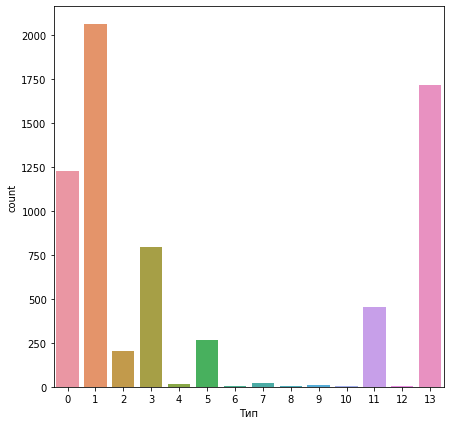

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize = (7, 7))
sns.countplot(x = df['Тип'])

In [ ]:
category_to_mapping['Тип']

{0: '1-комн. апарт.',
 1: '1-комн. кв.',
 2: '2-комн. апарт.',
 3: '2-комн. кв.',
 4: '3-комн. апарт.',
 5: '3-комн. кв.',
 6: '4-комн. апарт.',
 7: '4-комн. кв.',
 8: '5-комн. апарт.',
 9: '5-комн. кв.',
 10: '6-комн. кв.',
 11: 'апартаменты-студия',
 12: 'своб. планировка',
 13: 'студия'}

Вывод: рассматриваем только 1-комн. апарт. (0), 1-комн. кв. (1), 2-комн. кв. (3), студия (13)

##### Площадь

<Axes: xlabel='Площадь (м^2)', ylabel='Density'>

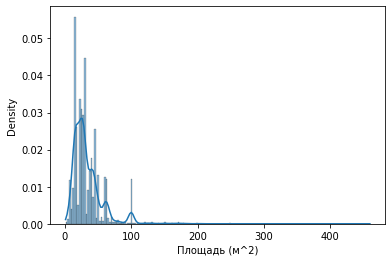

In [ ]:
sns.histplot(df['Площадь (м^2)'], kde = True, stat = "density")

<Axes: xlabel='Площадь (м^2)', ylabel='Density'>

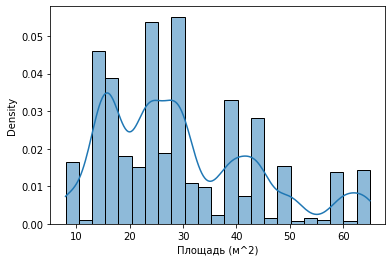

In [ ]:
sns.histplot(df['Площадь (м^2)'][(df['Площадь (м^2)'] >= 8) & (df['Площадь (м^2)'] <= 65)], kde = True, stat = "density")

Вывод: используем площадь в диапазоне [0; 65]

##### Станции

<Axes: xlabel='Станция', ylabel='count'>

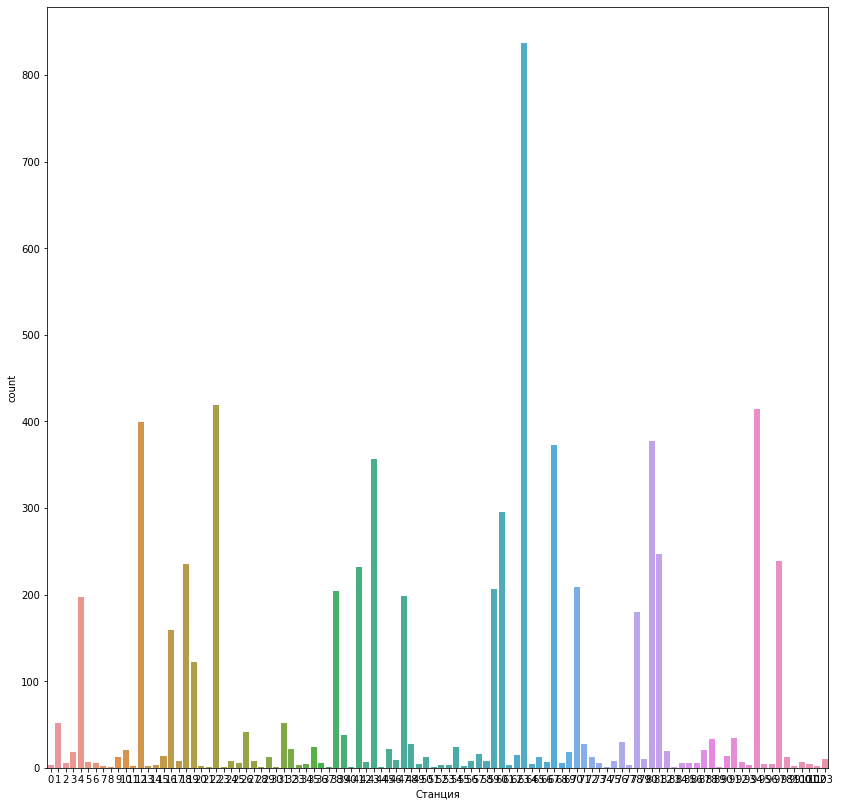

In [ ]:
plt.figure(figsize = (14, 14))
sns.countplot(x = df['Станция'])

([<matplotlib.patches.Wedge at 0x7fb81d91ddf0>,
 [Text(1.0611947393569872, 0.28959579617296993, '22'),
  Text(0.7694897518857908, 0.7860569456106499, '94'),
  Text(0.28047638544035375, 1.0636413856231406, '12'),
  Text(-0.25673891172045576, 1.0696191524129495, '80'),
  Text(-0.7190485297024259, 0.8324477232431955, '67'),
  Text(-1.0156306553476315, 0.4224859428645417, '43'),
  Text(-1.099772324087637, -0.02237934697166268, '60'),
  Text(-1.0275513086447727, -0.39260451869841645, '81'),
  Text(-0.8594848786504535, -0.6865025443297464, '97'),
  Text(-0.6169664110478916, -0.9106878980411919, '18'),
  Text(-0.32351458759654983, -1.0513507081902949, '41'),
  Text(-0.019931947393342208, -1.0998194022079757, '70'),
  Text(0.26828510063756356, -1.0667816574988027, '59'),
  Text(0.5347885886315573, -0.9612497934821453, '38'),
  Text(0.7604432563742392, -0.7948119613059075, '47'),
  Text(0.9341108244660202, -0.5808932497588625, '4'),
  Text(1.0453160327829247, -0.342511885351396, '78'),
  Text(1

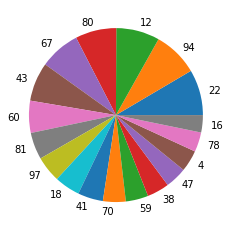

In [ ]:
series = df['Станция'].value_counts()
series_filtered = series.loc[lambda x: (x >= 150) & (x <= 430)]
plt.pie(series_filtered, labels = series_filtered.index)

Вывод: используем только станции, встречающиеся от 150 до 420 раз

##### Время до станции

<Axes: xlabel='Время до станции (мин)', ylabel='Density'>

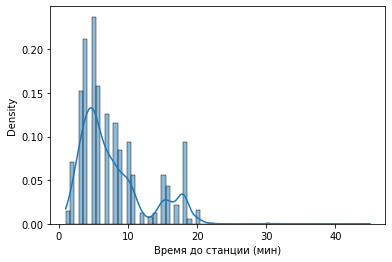

In [ ]:
sns.histplot(df['Время до станции (мин)'], kde = True, stat = "density")

<Axes: xlabel='Время до станции (мин)', ylabel='Density'>

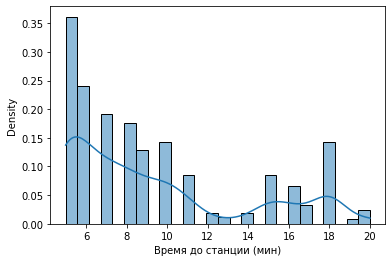

In [ ]:
sns.histplot(df['Время до станции (мин)'][(df['Время до станции (мин)'] >= 5) & (df['Время до станции (мин)'] <= 20)], kde = True, stat = "density")

Вывод: используем время в диапазоне [5; 20]

##### Пешком?

<Axes: xlabel='Пешком?', ylabel='count'>

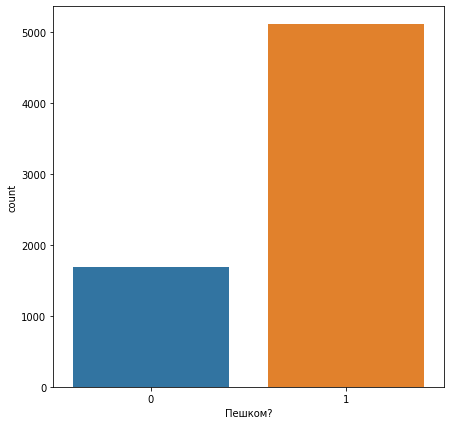

In [ ]:
plt.figure(figsize = (7, 7))
sns.countplot(x = df['Пешком?'])

Вывод: данные по этому параметру сильно не сбалансированы

##### Улица

<Axes: xlabel='Улица', ylabel='count'>

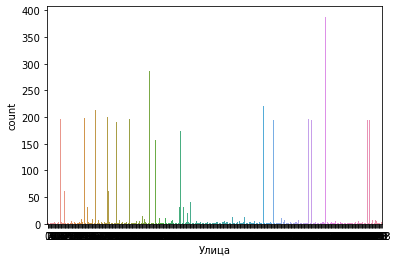

In [ ]:
sns.countplot(x = df['Улица'])

<Axes: >

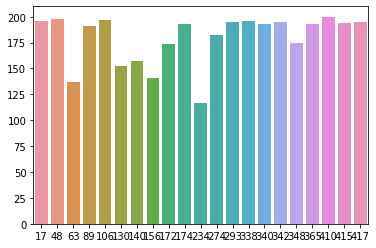

In [ ]:
series = df['Улица'].value_counts()
series_filtered = series.loc[lambda x: (x >= 75) & (x <= 200)]
sns.barplot(x = series_filtered.index, y = series_filtered.values)

Вывод: используем только улицы, встречающиеся от 75 до 200 раз

##### Цена в день

<Axes: xlabel='Цена в день (руб.)', ylabel='Density'>

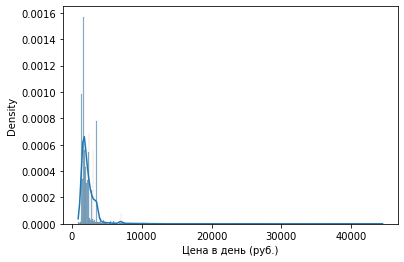

In [ ]:
sns.histplot(df['Цена в день (руб.)'], kde = True, stat = "density")

<Axes: xlabel='Цена в день (руб.)', ylabel='Density'>

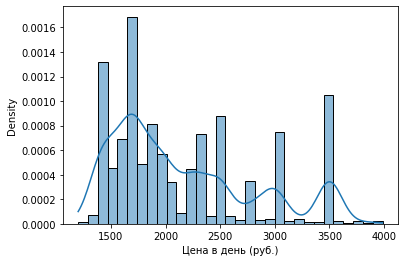

In [ ]:
sns.histplot(df['Цена в день (руб.)'][(df['Цена в день (руб.)'] >= 1200) & (df['Цена в день (руб.)'] < 4000)], kde = True, stat = "density")

Вывод: используем только цены в диапазоне [1200; 4000)

##### Залог

<Axes: xlabel='С залогом?', ylabel='count'>

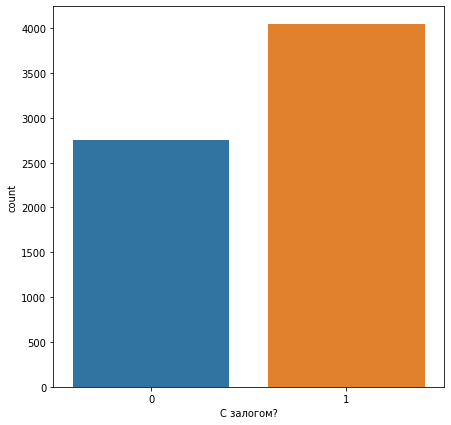

In [ ]:
plt.figure(figsize = (7, 7))
sns.countplot(x = df['С залогом?'])

<Axes: xlabel='Залог (руб.)', ylabel='Density'>

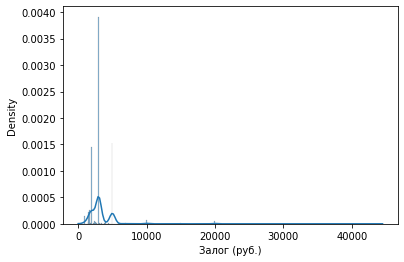

In [ ]:
sns.histplot(df['Залог (руб.)'][df['С залогом?'] == 1], kde = True, stat = "density")

<Axes: xlabel='Залог (руб.)', ylabel='Density'>

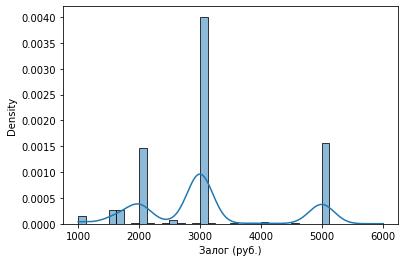

In [ ]:
sns.histplot(df['Залог (руб.)'][(df['С залогом?'] == 1) & (df['Залог (руб.)'] >= 1000) & (df['Залог (руб.)'] <= 6000)], kde = True, stat = "density")

Выводы:

- по наличию залога распределение хорошее
- видно, что залог целесообразнее разделить на классы "<3000", "3000", ">3000"

<Axes: xlabel='Залог (руб.)', ylabel='count'>

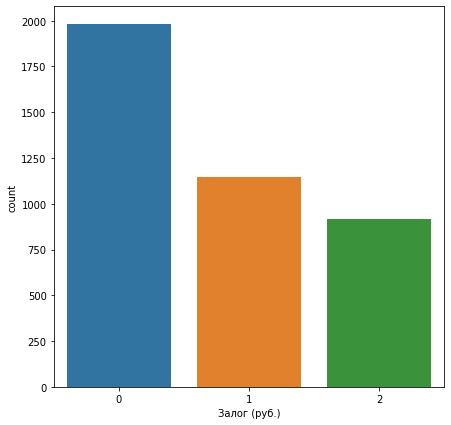

In [ ]:
def pledge_category(pledge):
  if pledge < 3000:
    return "<3000"
  elif pledge == 3000:
    return "3000"
  else:
    return ">3000"

df['Залог (руб.)'] = df['Залог (руб.)'].map(pledge_category)
df.convert_dtypes()

category_to_mapping['Залог (руб.)'] = categorize(df, 'Залог (руб.)')

plt.figure(figsize = (7, 7))
sns.countplot(x = df['Залог (руб.)'][df['С залогом?'] == 1])

#### Взаимодействия между признаками

##### Цена от площади и величины залога

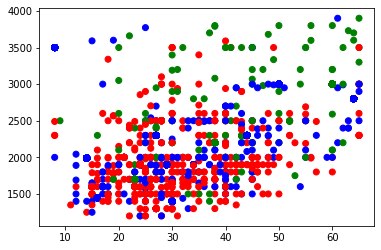

In [ ]:
df_area_price_pledge = df[
  (df['Площадь (м^2)'] >= 8) & (df['Площадь (м^2)'] <= 65) &
  (df['Цена в день (руб.)'] >= 1200) & (df['Цена в день (руб.)'] < 4000) &
  (df['С залогом?'] == 1)
]

plt.scatter(
  df_area_price_pledge['Площадь (м^2)'],
  df_area_price_pledge['Цена в день (руб.)'],
  color = df_area_price_pledge['Залог (руб.)'].map({0: 'blue', 1: 'red', 2: 'green'})
)

Выводы:

- хотя соотношение цены и площади далеко от взаимно однозначного, но очевидны участки с большей плотностью точек
- залог зависти от цены и площади (<2000, правый верхний угол, (45, 2000 - 3000))

##### Площадь от типа

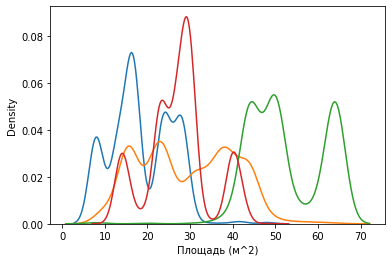

In [ ]:
types = (0, 1, 3, 13)

df_area_type = df[
  (df['Площадь (м^2)'] >= 8) & (df['Площадь (м^2)'] <= 65) & (df['Тип'].isin(types))
]

for i in types:
  sns.kdeplot(df_area_type['Площадь (м^2)'][df_area_type['Тип'] == i])

Вывод: тип связан с площадью

##### Этаж от количества этажей

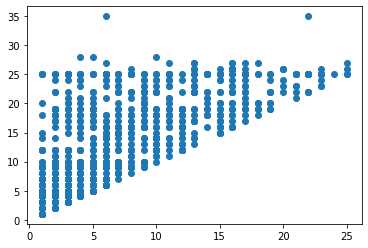

In [ ]:
df_floor_total = df[(df['Этаж'] <= 25) & (df['Всего этажей'] < 50)]
plt.scatter(df_floor_total['Этаж'], df_floor_total['Всего этажей'])

Вывод: они никак не связаны

##### Местоположение

740


<Axes: >

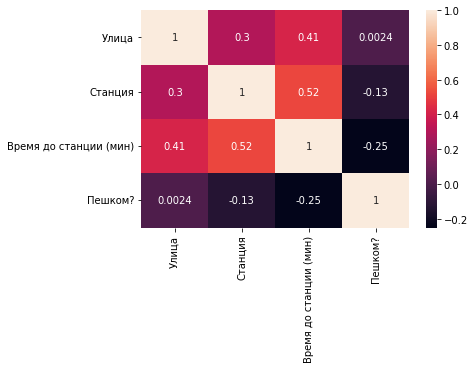

In [ ]:
streets_series = df['Улица'].value_counts().loc[lambda x: (x >= 75) & (x <= 200)]
station_series = df['Станция'].value_counts().loc[lambda x: (x >= 150) & (x <= 430)]

df_filtered = df[
  (df['Улица'].isin(streets_series.index)) &
  (df['Время до станции (мин)'] >= 5) & (df['Время до станции (мин)'] <= 20) &
  (df['Станция'].isin(station_series.index))
]

on_transport = df_filtered[df_filtered['Пешком?'] == 0]
on_transport_len = len(on_transport.index)
on_foot = df_filtered[df_filtered['Пешком?'] == 1].sample(n = on_transport_len)
df_street_station_time_foot = pd.concat([on_transport, on_foot]).sample(frac = 1)

print(len(df_street_station_time_foot.index))

sns.heatmap(df_street_station_time_foot[['Улица', 'Станция', 'Время до станции (мин)', 'Пешком?']].corr(), annot = True)

Выводы:

- время до станции коррелирует с улицей и станцией
- способ добраться до станции не зависит почти ни от чего

##### Цена от станции, площади и типа

3951


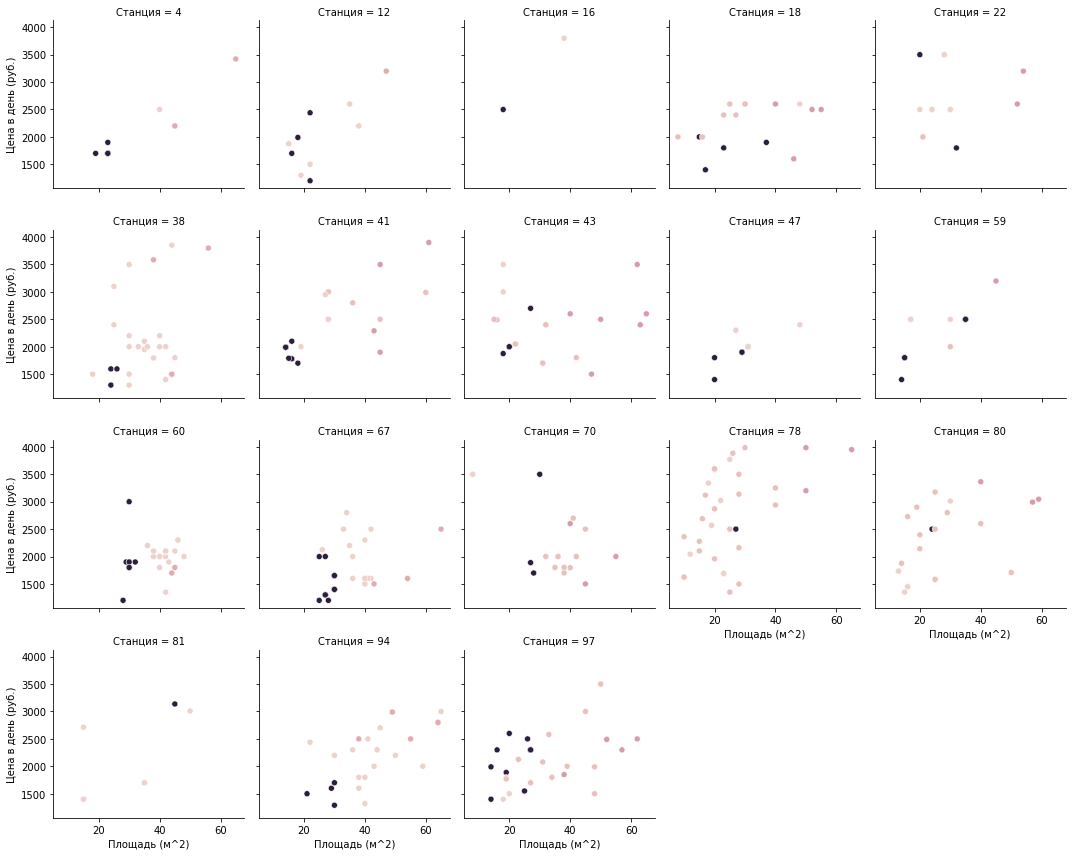

In [ ]:
df_area_price_station_type = df[
  (df['Площадь (м^2)'] >= 8) & (df['Площадь (м^2)'] <= 65) &
  (df['Цена в день (руб.)'] >= 1200) & (df['Цена в день (руб.)'] < 4000) &
  (df['Станция'].isin(station_series.index)) &
  (df['Тип'].isin(types))
]

print(len(df_area_price_station_type.index))

grid = sns.FacetGrid(df_area_price_station_type, col = 'Станция', col_wrap = 5)
grid.map_dataframe(
  sns.scatterplot, hue = 'Тип',
  x = 'Площадь (м^2)', y = 'Цена в день (руб.)'
)

Вывод: между ними есть существенная зависимоть

## III. Предсказания

### Выбор целевых переменных

Согласно сделанным ранее выводам, имеет смысл делать следующие предсказания:

- площадь -> тип
- (цена, площадь) -> залог
- (улица, станция) -> время
- (площадь, станция, тип) -> цена

### Выбор моделей

#### площадь -> тип

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

y = df_area_type['Тип']
x = df_area_type[['Площадь (м^2)']]

models = {
  '\tSVC': LinearSVC(),
  'Logistic Regression': LogisticRegression(),
  'Boosting': GradientBoostingClassifier()
}

x_train, x_test, y_train, y_test = train_test_split(
  x, y, train_size = 0.75, random_state = 1488
)

for name, model in models.items():
  model.fit(x_train, y_train)
  print(name, classification_report(model.predict(x_test), y_test), sep = '\n')

	SVC
              precision    recall  f1-score   support

           0       0.32      0.57      0.41       175
           1       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
          13       0.88      0.29      0.44      1249

    accuracy                           0.32      1424
   macro avg       0.30      0.21      0.21      1424
weighted avg       0.81      0.32      0.43      1424

Logistic Regression
              precision    recall  f1-score   support

           0       0.60      0.48      0.54       387
           1       0.58      0.37      0.45       817
           3       0.71      0.86      0.78       153
          13       0.01      0.04      0.01        67

    accuracy                           0.44      1424
   macro avg       0.47      0.44      0.44      1424
weighted avg       0.57      0.44      0.49      1424

Boosting
              precision    recall  f1-score   support

           0       0.67      0.93      0.

Вывод: используем Boosting

#### (цена, площадь) -> залог

In [ ]:
y = df_area_price_pledge['Залог (руб.)']
x = df_area_price_pledge[['Цена в день (руб.)', 'Площадь (м^2)']]

models = {
  '\tSVC': LinearSVC(),
  'Logistic Regression': LogisticRegression(),
  'Boosting': GradientBoostingClassifier()
}

x_train, x_test, y_train, y_test = train_test_split(
  x, y, train_size = 0.75, random_state = 228
)

for name, model in models.items():
  model.fit(x_train, y_train)
  print(name, classification_report(model.predict(x_test), y_test), sep = '\n')

	SVC
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.46      0.36      0.41       330
           2       0.95      0.28      0.43       608

    accuracy                           0.31       938
   macro avg       0.47      0.21      0.28       938
weighted avg       0.78      0.31      0.42       938

Logistic Regression
              precision    recall  f1-score   support

           0       0.79      0.62      0.70       644
           1       0.53      0.47      0.50       292
           2       0.00      0.00      0.00         2

    accuracy                           0.57       938
   macro avg       0.44      0.36      0.40       938
weighted avg       0.71      0.57      0.63       938

Boosting
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       495
           1       0.90      0.84      0.87       275
           2       0.90      0.95      0.

Вывод: снова Boosting лучше

#### (улица, станция) -> время

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y = df_filtered['Время до станции (мин)']
x = df_filtered[['Улица', 'Станция']]

models = {
  'Linear Regression': LinearRegression(),
  'Decision Tree': DecisionTreeRegressor(),
  'SVR': SVR()
}

x_train, x_test, y_train, y_test = train_test_split(
  x, y, train_size = 0.75, random_state = 228
)

def report(models, x_train, x_test, y_train, y_test):
  for name, model in models.items():
    model.fit(x_train, y_train)
    mae = mean_absolute_error(y_test, model.predict(x_test))
    mse = mean_squared_error(y_test, model.predict(x_test))
    r2s = r2_score(y_test, model.predict(x_test))
    print(name)
    print('\tMAE = {}\tMSE = {}\tR2S = {}'.format(mae, mse, r2s))

report(models, x_train, x_test, y_train, y_test)

Linear Regression
	MAE = 3.5455415001970394	MSE = 17.5135536490615	R2S = 0.1366866329744585
Decision Tree
	MAE = 0.052795658496893286	MSE = 0.1670623099102013	R2S = 0.9917648280776318
SVR
	MAE = 2.3259447363648174	MSE = 13.380663127497154	R2S = 0.34041339815388616


Вывод: используем Decision Tree

#### (площадь, станция, тип) -> цена

In [ ]:
y = df_area_price_station_type['Цена в день (руб.)']
x = df_area_price_station_type[['Площадь (м^2)', 'Станция', 'Тип']]

models = {
  'Linear Regression': LinearRegression(),
  'Decision Tree': DecisionTreeRegressor(),
  'SVR': SVR()
}

x_train, x_test, y_train, y_test = train_test_split(
  x, y, train_size = 0.75, random_state = 228
)

report(models, x_train, x_test, y_train, y_test)

Linear Regression
	MAE = 467.7988837511065	MSE = 347943.90821425384	R2S = 0.12625009785012142
Decision Tree
	MAE = 57.57232950652999	MSE = 56043.972862586954	R2S = 0.8592634771044118
SVR
	MAE = 444.1741137513657	MSE = 374206.1365558805	R2S = 0.06030090632237606


Вывод: используем SVR

### Тренировка моделей и подбор параметров

#### (площадь, станция, тип) -> цена

In [ ]:
from sklearn.model_selection import GridSearchCV

y = df_area_price_station_type['Цена в день (руб.)']
x = df_area_price_station_type[['Площадь (м^2)', 'Станция', 'Тип']]

x_train, x_test, y_train, y_test = train_test_split(
  x, y, train_size = 0.75, random_state = 8800
)

model = SVR()

params_poly = {
  'kernel': ['poly'],
  'degree': [1, 2, 3],
  'tol': [1e-2, 1e-3, 1e-4, 1e-5],
  'C': [1, 2, 4, 8],
  'epsilon': [0.1, 0.05, 0.025, 0.125]
}

params_non_poly = {
  'kernel': ['linear', 'rbf', 'sigmoid'],
  'gamma': ['scale', 'auto'],
  'tol': [1e-2, 1e-3, 1e-4, 1e-5],
  'C': [1, 2, 4, 8],
  'epsilon': [0.1, 0.05, 0.025, 0.125]
}

gs_p = GridSearchCV(estimator = model, param_grid = params_poly, cv = 4)
gs_np = GridSearchCV(estimator = model, param_grid = params_non_poly, cv = 4)

gs_p.fit(x_train, y_train)
gs_np.fit(x_train, y_train)

def report_grid_search(grid_search, x_train, x_test, y_train, y_test):
  print(f'Best params: {grid_search.best_params_}\n')

  best_model = grid_search.best_estimator_
  best_model.fit(x_train, y_train)
  y_pred = best_model.predict(x_test)

  print('MSE: ', mean_squared_error(y_test, y_pred))
  print('MAE: ', mean_absolute_error(y_test, y_pred))
  print('R2: ', r2_score(y_test, y_pred))

report_grid_search(gs_p, x_train, x_test, y_train, y_test)
report_grid_search(gs_np, x_train, x_test, y_train, y_test)

Best params: {'C': 8, 'degree': 1, 'epsilon': 0.025, 'kernel': 'poly', 'tol': 0.01}

MSE:  366872.0724709288
MAE:  446.4499875982053
R2:  0.0335198719254326
Best params: {'C': 8, 'epsilon': 0.125, 'gamma': 'auto', 'kernel': 'rbf', 'tol': 1e-05}

MSE:  42411.85531151236
MAE:  81.5678275983627
R2:  0.8882710938522076


#### (улица, станция) -> время

In [ ]:
y = df_filtered['Время до станции (мин)']
x = df_filtered[['Улица', 'Станция']]

model = DecisionTreeRegressor()

x_train, x_test, y_train, y_test = train_test_split(
  x, y, train_size = 0.75, random_state = 228
)

params = {
  'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
  'splitter': ['best', 'random'],
  'min_samples_split': [2, 4, 8],
  'min_samples_leaf': [1, 2, 4],
  'max_features': ['auto', 'sqrt', 'log2']
}

gs = GridSearchCV(estimator = model, param_grid = params, cv = 4)
gs.fit(x_train, y_train)

report_grid_search(gs, x_train, x_test, y_train, y_test)

Best params: {'criterion': 'poisson', 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'best'}

MSE:  0.2772601815215786
MAE:  0.0738775342914865
R2:  0.9863327325996838


#### (цена, площадь) -> залог

In [ ]:
y = df_area_price_pledge['Залог (руб.)']
x = df_area_price_pledge[['Цена в день (руб.)', 'Площадь (м^2)']]

model = GradientBoostingClassifier()

x_train, x_test, y_train, y_test = train_test_split(
  x, y, train_size = 0.75, random_state = 228
)

params = {
  'loss': ['log_loss', 'deviance'],
  'learning_rate': [0.01, 0.1, 1],
  'criterion': ['friedman_mse', 'squared_error'],
  'max_features': ['auto', 'sqrt', 'log2']
}

gs = GridSearchCV(estimator = model, param_grid = params, cv = 4)
gs.fit(x_train, y_train)

print(f'\nBest params: {gs.best_params_}\n')

best_model = gs.best_estimator_
best_model.fit(x_train, y_train)

print(classification_report(best_model.predict(x_test), y_test))


Best params: {'criterion': 'friedman_mse', 'learning_rate': 1, 'loss': 'log_loss', 'max_features': 'log2'}

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       491
           1       0.89      0.87      0.88       265
           2       0.90      0.88      0.89       182

    accuracy                           0.92       938
   macro avg       0.91      0.90      0.91       938
weighted avg       0.92      0.92      0.92       938



#### площадь -> тип

In [ ]:
y = df_area_type['Тип']
x = df_area_type[['Площадь (м^2)']]

model = GradientBoostingClassifier()

x_train, x_test, y_train, y_test = train_test_split(
  x, y, train_size = 0.75, random_state = 31245
)

gs = GridSearchCV(estimator = model, param_grid = params, cv = 4)
gs.fit(x_train, y_train)

print(f'\nBest params: {gs.best_params_}\n')

best_model = gs.best_estimator_
best_model.fit(x_train, y_train)

print(classification_report(best_model.predict(x_test), y_test))


Best params: {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'log_loss', 'max_features': 'auto'}

              precision    recall  f1-score   support

           0       0.60      0.95      0.73       207
           1       0.86      0.68      0.76       622
           3       0.69      0.96      0.80       128
          13       0.92      0.84      0.88       467

    accuracy                           0.79      1424
   macro avg       0.77      0.86      0.79      1424
weighted avg       0.82      0.79      0.80      1424

